# Preventing Overfitting in Random Forest Estimate
In this notebook, we will try to prevent overfitting of our random forest estimate. We will quickly copy all the code over from Simple Converge into here.

## Sampling Code

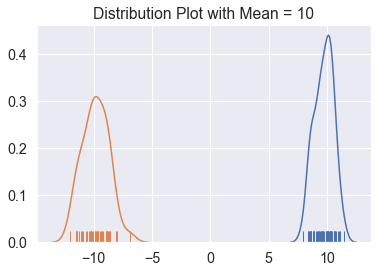

In [2]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 10, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 10")
plt.show()

## Original Algorithm Code

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def estimate_conditional_entropy(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth, random_state = 0)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

### Ok, now that the code has been imported. We will revisit the case where all entropies drop to 0.
Remember that this happens when we do not set a maximum depth to our trees

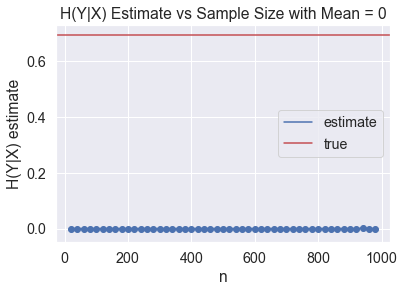

In [6]:
np.warnings.filterwarnings('ignore')

def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 20, bootstrap = False))
    return sample_sizes, conditional_entropy


sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

## Test Number 1: Bootstrapping at 63%
We will change our classifier to use the Bagging classifier of Decision trees. Use all the features but only 63% of samples in each tree

In [84]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

def estimate_conditional_entropy(X, y, n_trees = 100, max_samples = 1., max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(), n_estimators = n_trees, max_samples= max_samples, max_features= max_features, oob_score = False, bootstrap = True)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)


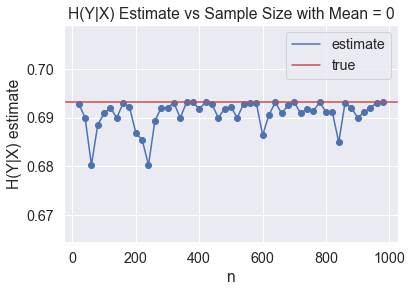

In [87]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 500, 1))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

Didn't work. What if we switch impurity to entropy?

In [88]:
def estimate_conditional_entropy_ent(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth, random_state = 0, criterion = "entropy")
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

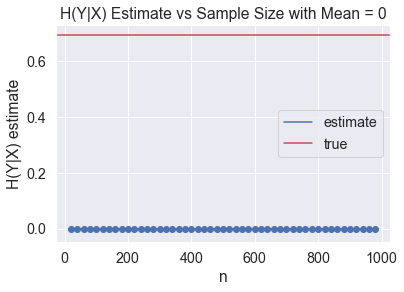

In [89]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy_ent(np.array(X).reshape(-1, 1), y, 500))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()